In [1]:
import os
import sys
import math
import argparse
import numpy as np
from collections import Counter

from scipy import ndimage
from biosppy.signals.ecg import ecg

# Keras imports
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# ML4CVD Imports
from ml4cvd.arguments import parse_args
from ml4cvd.models import make_multimodal_multitask_model, train_model_from_generators
from ml4cvd.tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators
from ml4cvd.defines import ECG_REST_LEADS

# IPython imports
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt


In [10]:
def gradients_from_output(args, model, output_layer, output_index):
    K.set_learning_phase(1)
    input_tensor = model.input
    x = model.get_layer(output_layer).output[:,output_index]
    grads = K.gradients(x, input_tensor)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6) # normalization trick: we normalize the gradient
    iterate = K.function([input_tensor], [x, grads])
    return iterate

def saliency_map(input_tensor, model, output_layer, output_index):
    get_gradients = gradients_from_output(args, model, output_layer, output_index)
    activation, grads = get_gradients([input_tensor])
    #print('Activation is:', activation, 'gradient shape:', grads.shape)
    return grads


In [3]:
def plot_ecgs(ecgs, rows=3, cols=4, time_interval=2.5, raw_scale=0.005, hertz=500):
    _, axes = plt.subplots(rows, cols, figsize=(18, 16))
    for i in range(rows):
        for j in range(cols):
            start = int(i*time_interval*hertz)
            stop = int((i+1)*time_interval*hertz)
            axes[i, j].set_xlim(start, stop)
            for label in ecgs:
                axes[i, j].plot(range(start, stop), ecgs[label][start:stop, j + i*cols] * raw_scale, label=label)  
            axes[i, j].legend(loc='lower right')
            axes[i, j].set_xlabel('milliseconds')

In [9]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/ecg-rest-38k-tensors/2020-03-14/', 
            '--input_tensors', 'ecg_rest_raw', 
            '--output_tensors', 'adjusted_myocardium_mass_asym_outlier_no_poor',
            '--batch_size', '36',
            '--epochs', '2',
            '--conv_x', '71',
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '100',
            '--num_workers', '0',
            '--test_csv', '/home/sam/ml/lvh_hold_out.txt',
            '--model_file', '/home/sam/ml/trained_models/ecg_rest_raw_amm_asym_outlier_pretrained_v3/ecg_rest_raw_amm_asym_outlier_pretrained_v3.h5',
            '--id', 'ecg_rest_qt_only']
args = parse_args()
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
model = make_multimodal_multitask_model(**args.__dict__)
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
# test_data, test_labels, test_paths = big_batch_from_minibatch_generator(generate_test, args.test_steps)
# test_tensor = test_data['input_ecg_rest_raw_continuous']
# grads_qt = saliency_map(test_tensor, model, 'output_adjusted_myocardium_mass_continuous', 0)

2020-06-12 07:40:49,465 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/ecg_rest_qt_only/log_2020-06-12_07-40_0.log.
2020-06-12 07:40:49,466 - arguments:402 - INFO - Command Line was: 
./scripts/tf.sh train --tensors /mnt/disks/ecg-rest-38k-tensors/2020-03-14/ --input_tensors ecg_rest_raw --output_tensors adjusted_myocardium_mass_asym_outlier_no_poor --batch_size 36 --epochs 2 --conv_x 71 --learning_rate 0.001 --training_steps 128 --validation_steps 10 --test_steps 100 --num_workers 0 --test_csv /home/sam/ml/lvh_hold_out.txt --model_file /home/sam/ml/trained_models/ecg_rest_raw_amm_asym_outlier_pretrained_v3/ecg_rest_raw_amm_asym_outlier_pretrained_v3.h5 --id ecg_rest_qt_only

2020-06-12 07:40:49,467 - arguments:403 - INFO - Total TensorMaps: 631 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=3

2020-06-12 07:40:52,523 - tensor_generators:653 - INFO - Found 25399 train, 6389 validation, and 5452 testing tensors at: /mnt/disks/ecg-rest-38k-tensors/2020-03-14/


In [13]:
def stretch_ecg(x, gradients, n):
    """
    stretches input ECG to n bpm
    """
    out = ecg(x.copy(), sampling_rate=500, show=False)
    hr = out[-1].mean()
    t = np.arange(len(x))
    tp = np.arange(len(x)) * n / hr
    stretched = np.interp(tp, t, x)
    #print(f'{x.shape} and {stretched.shape}')
    out2 = ecg(stretched, show=False)
    return stretched, np.interp(tp, t, gradients), out2[2]

In [14]:
def align_waves_and_gradients(test_tensor, gradients, median_size=500, use_median=True, use_abs=False, bpm=60):
    grads_stretched = gradients.copy()
    
    all_waves = []
    grads = []
    for k in range(test_tensor.shape[-1]):
        lead_waves = []
        lead_grads = []
        for i in range(len(test_tensor)):
            stretched, grads_stretched, peaks = stretch_ecg(test_tensor[i, :, k], gradients[i, :, k], bpm)
            waves = []
            wave_grads = []
            for j, p0 in enumerate(peaks[:-2]):
                p11 = peaks[j+1]
                p22 = peaks[j+2]
                p0 = (p0+p11)//2
                p1 = p22# = (p11+p22)//2
                if p1-p0 < 400:
                    continue
                waves.append(np.interp(np.arange(median_size), np.arange(p1-p0), 20*stretched[p0:p1]))
                wave_grads.append(np.interp(np.arange(median_size), np.arange(p1-p0), 100*grads_stretched[p0:p1]))
            waves = np.array(waves)
            waves -= np.mean(waves)
            wave_grads = np.array(wave_grads)
            if use_median:
                waves = np.median(waves, axis=0)
                wave_grads = np.median(wave_grads, axis=0)
            else:
                waves = np.mean(waves, axis=0)
                wave_grads = np.mean(wave_grads, axis=0)                
            if use_abs:
                wave_grads = np.abs(wave_grads)
            
            lead_waves.append(waves)  
            lead_grads.append(wave_grads)
        all_waves.append(lead_waves)
        grads.append(lead_grads)
    return np.array(all_waves), np.array(grads)

In [15]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
#r_amps = [1435, 942, 131, 415, 708, 791, 1210, 1152, 961, 493, 966, 68]
#s_amps = [0, 0, 493, 1235, 1645, 913, 410, 68, 0, 0, 131, 1191]
r_amps = [454, 1342, 937, 83, 83, 161, 512, 1445, 1591, 1142, 39, 34]
s_amps = [180, 0, 0, 957, 927, 786, 458, 268, 136, 0, 346, 874]
def plot_ecg_saliency(waves, grads, color_map, blur=1, lead_dictionary=ECG_REST_LEADS, y_max=3.98):
    fig, ax = plt.subplots(4, 3, figsize=(16, 10), sharex=True)
    index2leads = {v: k for k, v in lead_dictionary.items()}
    for i in range(len(waves)):
        for w in waves[i]:
            ax[i%4, i//4].plot(w, color='#E31A1C')
            break
        g = np.tile(grads[i], (waves.shape[-1], 1))
        g = ndimage.gaussian_filter(g, sigma=blur)
        a = ax[i%4, i//4].imshow(g, cmap=color_map, aspect='auto', extent=[0, waves.shape[-1], -y_max, y_max])
        ax[i%4, i//4].set_title(index2leads[i])
        ax[i%4, i//4].set_ylabel('mV')
        ax[i%4, i//4].set_ylim(-y_max, y_max)
        ax[i%4, i//4].text(10, y_max-0.8, f'R:{r_amps[i]} S:{s_amps[i]}')
        cb = plt.colorbar(a, ax=ax[i%4, i//4], ticks=[g.min()+5, g.max()-5])
        cb.set_label('Salience')
        cb.ax.set_yticklabels(['Low', 'High'])
    plt.tight_layout()
    plt.show()

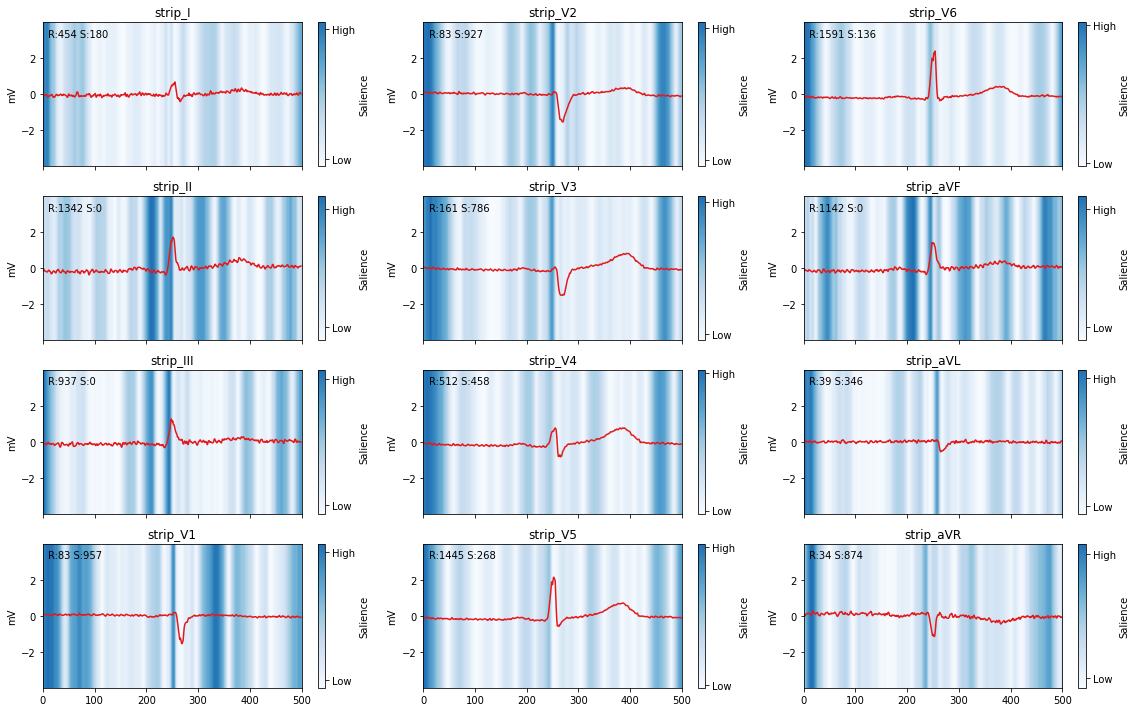

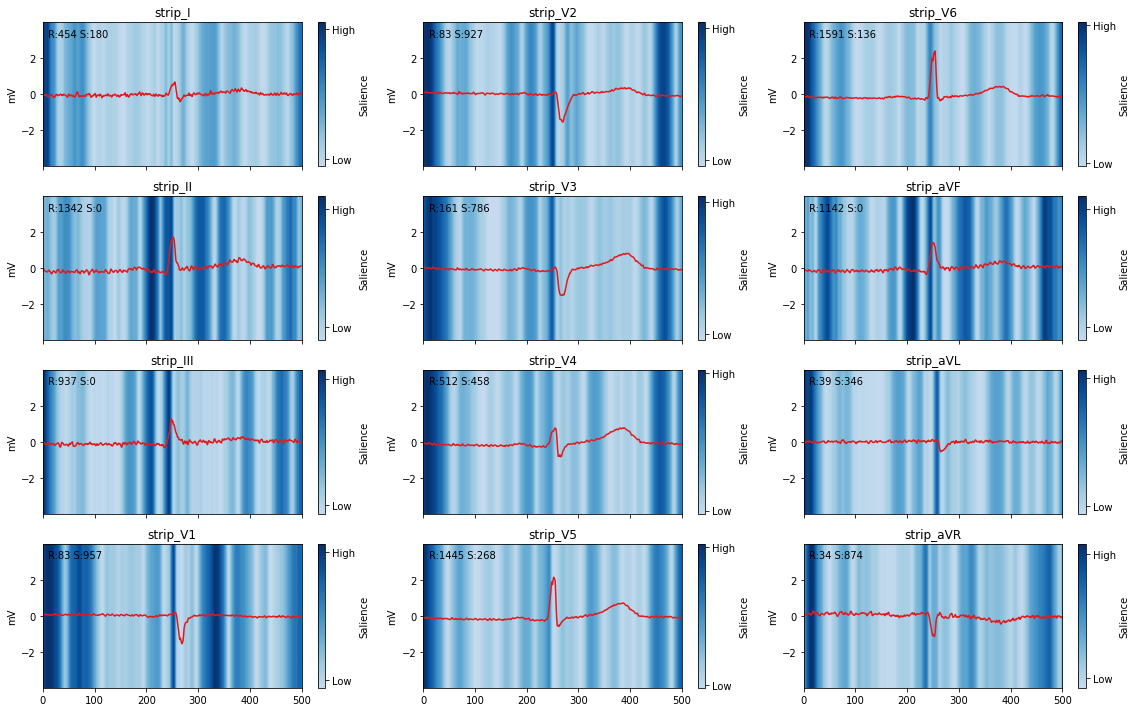

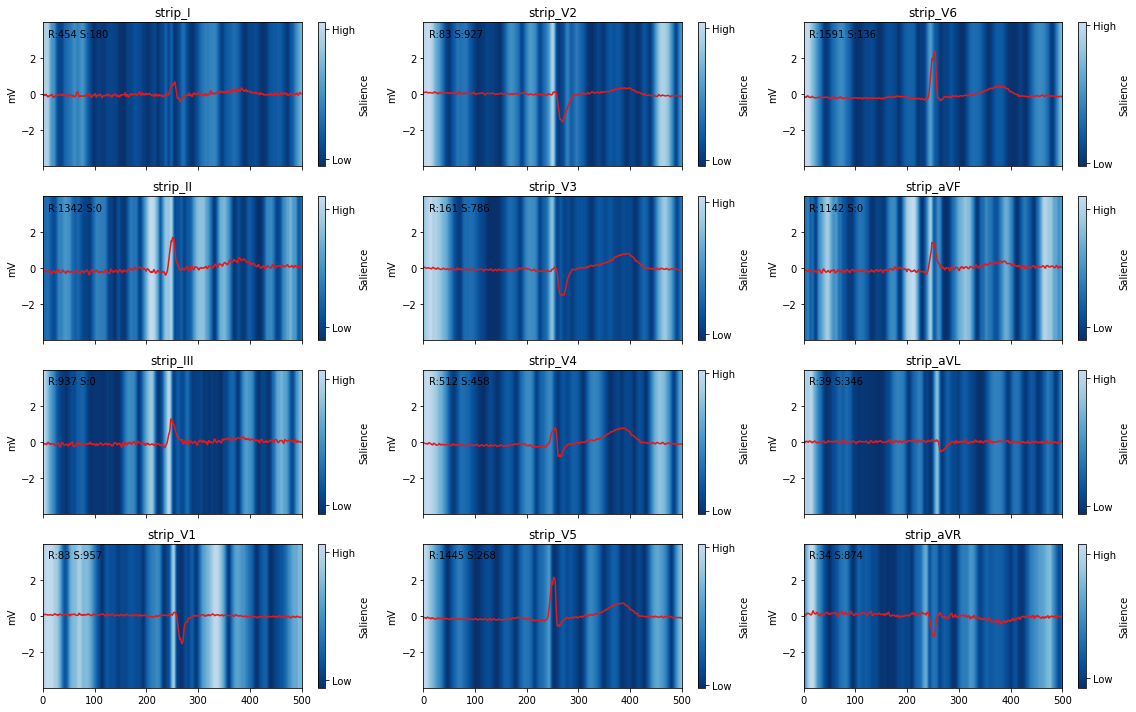

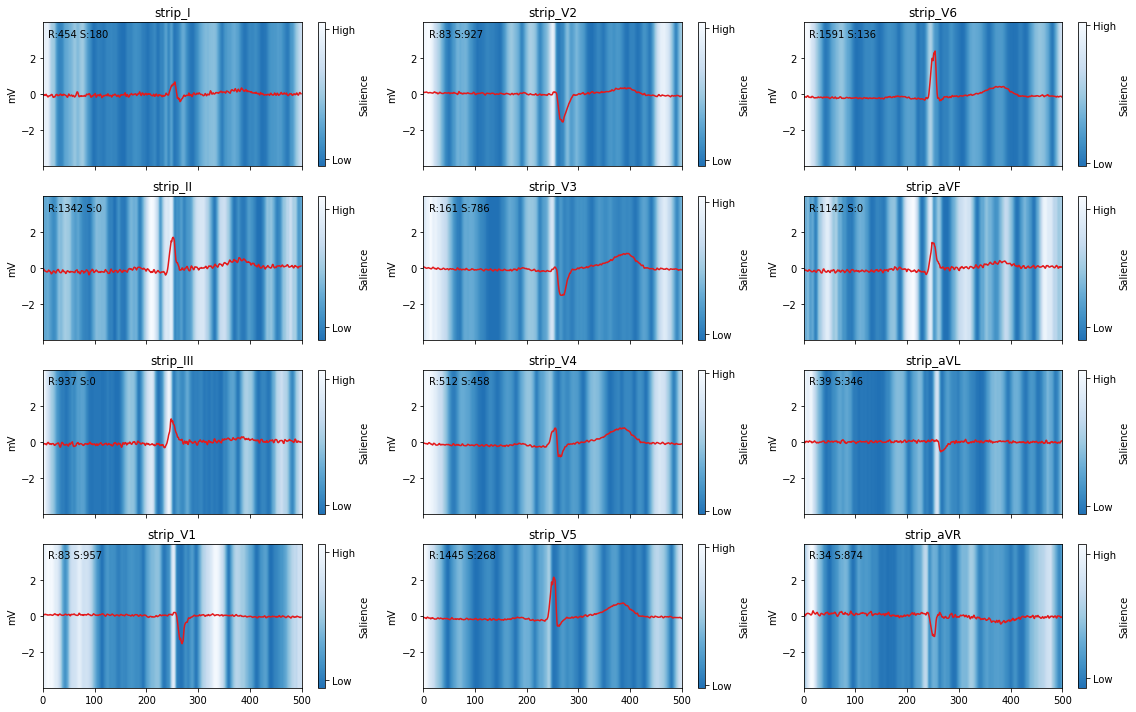

In [16]:
waves, grads = align_waves_and_gradients(test_tensor, grads_qt, use_median=True, use_abs=True)

for blur in [2]:
    for color_map in ['Blues', 'Blues_r']:
        blues = cm.get_cmap(color_map, 512)
        newcmp = ListedColormap(blues(np.linspace(0.0, 0.75, 256)))
        plot_ecg_saliency(waves, grads, color_map=newcmp, blur=blur)
        newcmp = ListedColormap(blues(np.linspace(0.25, 1.0, 256)))
        plot_ecg_saliency(waves, grads, color_map=newcmp, blur=blur)

In [ ]:
stats = Counter()
idx2lead = {v: k for k, v in ECG_REST_LEADS.items()}
for _ in range(180):
    test_data, _, _, _ = next(generate_test)
    test_tensor = test_data['input_ecg_rest_raw_continuous']
    gradients = saliency_map(test_tensor, model, 'output_adjusted_myocardium_mass_continuous', 0)
    values, counts = np.unique(np.argmax(np.sum(np.abs(gradients), axis=1), axis=-1), return_counts=True)
    for v, c in zip(values, counts):
        stats[idx2lead[v]] += c
    print(stats)

2020-06-12 07:41:22,676 - tensor_generators:151 - INFO - Started 1 test workers with cache size 0.000 GB.
Counter({'strip_V5': 34, 'strip_V1': 1, 'strip_V4': 1})
Counter({'strip_V5': 69, 'strip_V4': 2, 'strip_V1': 1})
Counter({'strip_V5': 104, 'strip_V4': 3, 'strip_V1': 1})
Counter({'strip_V5': 138, 'strip_V4': 5, 'strip_V1': 1})
Counter({'strip_V5': 174, 'strip_V4': 5, 'strip_V1': 1})
Counter({'strip_V5': 207, 'strip_V4': 7, 'strip_V1': 2})
Counter({'strip_V5': 243, 'strip_V4': 7, 'strip_V1': 2})
Counter({'strip_V5': 279, 'strip_V4': 7, 'strip_V1': 2})
Counter({'strip_V5': 314, 'strip_V4': 8, 'strip_V1': 2})
Counter({'strip_V5': 349, 'strip_V4': 9, 'strip_V1': 2})
Counter({'strip_V5': 385, 'strip_V4': 9, 'strip_V1': 2})
Counter({'strip_V5': 421, 'strip_V4': 9, 'strip_V1': 2})
Counter({'strip_V5': 457, 'strip_V4': 9, 'strip_V1': 2})
Counter({'strip_V5': 493, 'strip_V4': 9, 'strip_V1': 2})
Counter({'strip_V5': 529, 'strip_V4': 9, 'strip_V1': 2})
Counter({'strip_V5': 563, 'strip_V4': 11,

Counter({'strip_V5': 4837, 'strip_V4': 117, 'strip_V1': 14})
Counter({'strip_V5': 4871, 'strip_V4': 119, 'strip_V1': 14})
Counter({'strip_V5': 4907, 'strip_V4': 119, 'strip_V1': 14})
Counter({'strip_V5': 4942, 'strip_V4': 120, 'strip_V1': 14})
Counter({'strip_V5': 4977, 'strip_V4': 121, 'strip_V1': 14})


In [ ]:
print(np.unique(np.argmax(np.sum(np.abs(all_gradients), axis=1), axis=-1), return_counts=True))

In [13]:
print(ECG_REST_LEADS)

{'strip_I': 0, 'strip_II': 1, 'strip_III': 2, 'strip_V1': 3, 'strip_V2': 4, 'strip_V3': 5, 'strip_V4': 6, 'strip_V5': 7, 'strip_V6': 8, 'strip_aVF': 9, 'strip_aVL': 10, 'strip_aVR': 11}
